In [40]:
# Standard library imports
import numpy as np
import pandas as pd
import ast
import os
import sys
from os.path import dirname as up
from tqdm.notebook import tqdm

# Important directories
code_dir = os.path.dirname(os.getcwd())
deep_cal_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Allows to import my own module
sys.path.insert(0, code_dir)

from pricing.legacyliftedheston import Legacy_Pricer_Lifted_Heston
import pricing_model
from pricing.heston_fourier import price_heston_fourier
from pricing.heston_mc import price_heston_mc

from torch.utils.data import DataLoader
from torch import nn, optim
import torch
import seaborn as sns

from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go

In [61]:
input_ = []
heston_output = []
prediction = []
S = tqdm(np.arange(0.5,1.6,0.1), desc="S")
for i in S:
    for j in [0.3,0.5,0.7,0.9,1.1,1.4,1.6]:
        #c = price_heston_fourier(K_=i,alpha_=1.,r_=0.03,tau_=j,kappa_=2,S0_=1,theta_=0.04,rho_=-0.7,sigma_=0.5,V0_=0.04,L_=100)
        #c = price_heston_mc(kappa_=2,theta_=0.04,sigma_=0.5,rho_=-0.7,r_=0.03,T_=j,L_=100,V0_=0.04,S0_=1,K0_=i,N_=10000)
        c = Legacy_Pricer_Lifted_Heston(K_=1,r_=0.05,S0=i,T=j,rho=-0.3,lamb=1.5,nu=0.2,theta=0.3,V0=0.1,N=20,rN=2.5,alpha=0.6,M=200,L_=50)  # K_,r_,S0,T,rho,lamb,theta,nu,V0,N,rN,alpha,M,L_
        heston_output.append(c)
        input_.append([i,j,c]) 
input_ = np.array(input_)

In [62]:
heston_output = np.array(heston_output)
heston_output = np.reshape(heston_output, (11,8))

x, y = np.log(np.linspace(5,15,11)/10), np.linspace(5,15,11)/10

xx, yy = np.meshgrid(x, y, sparse=False)
fig = go.Figure(data=go.Surface(x=y, y=x, z=heston_output))
fig.update_layout(title='Price', autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))


ValueError: cannot reshape array of size 77 into shape (11,8)

In [64]:
import scipy as scp
brent_output = [] # 1.,1,0.02,j,1.5,i,0.1,-0.05,0.3,0.1,50
for i in input_ :
    try :
        brent_ = implied_volatility(i[2],1, i[0], i[1], 0.01, 'c')
    except:
        brent_ = np.nan
    #brent_ = scp.optimize.brentq(lambda x: pricing_model.call_option_brent(x,1,i[1],0.03,i[0],i[2]),-1,1)
    #brent_ = newton_raphson(S_=i[0],K_=1,r_=0.05,tau_=i[2], sigma0_=1 ,price_=i[1], epsilon_=1e-8)
    brent_output.append(brent_)
brent_output = np.array(brent_output)
brent_output = np.reshape(brent_output, (11,7))


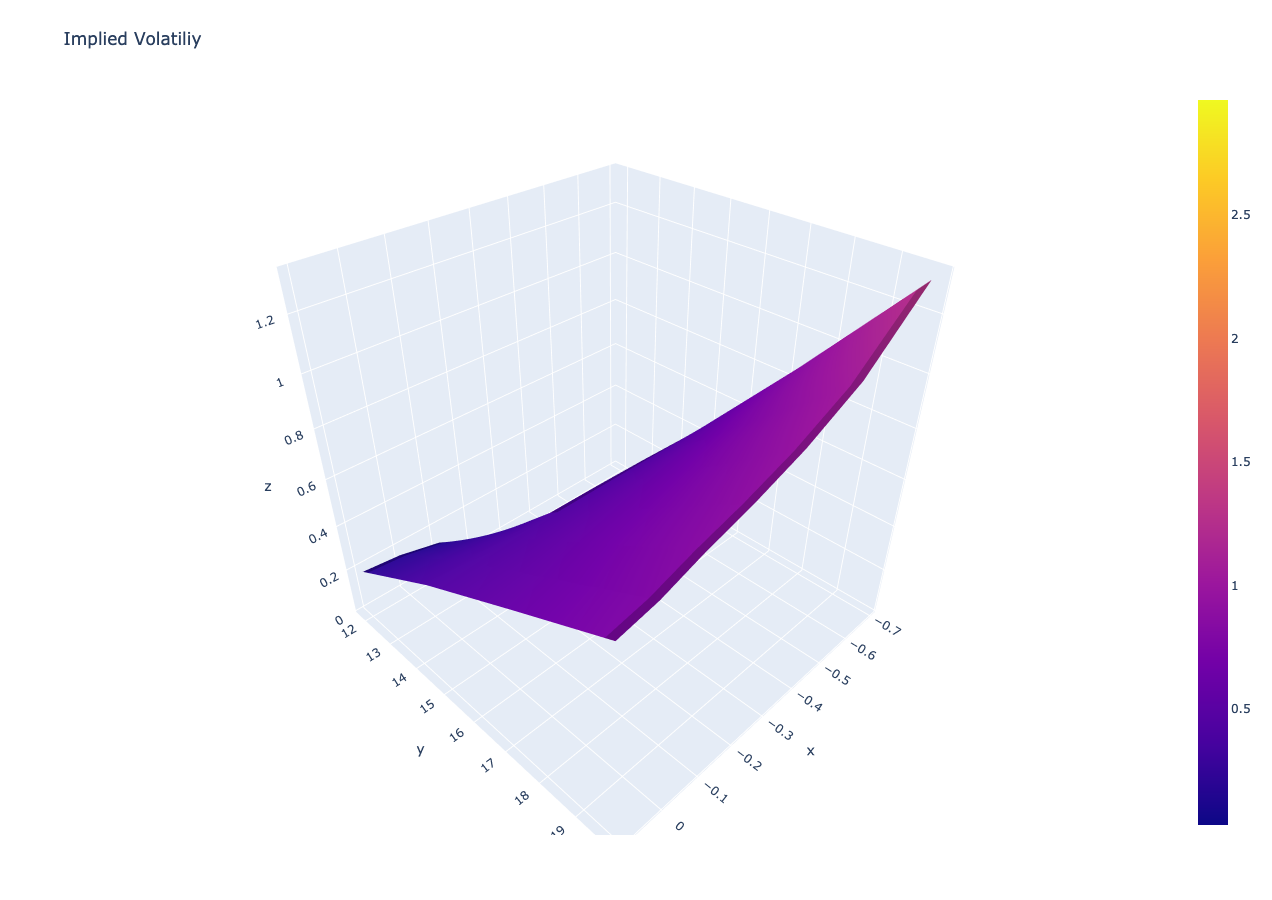

In [65]:

x, y = np.log(np.linspace(5,15,11)/10), np.linspace(1,20,8)
xx, yy = np.meshgrid(x, y, sparse=False)

fig = go.Figure(data=go.Surface(x=x, y=y, z=brent_output))
fig.update_layout(title='Implied Volatiliy', autosize=False,
                  width=900, height=900,
                  margin=dict(l=65, r=50, b=65, t=90))


In [66]:
%matplotlib inline

nb_samples_moneyness = 20
nb_samples_maturities = 20

# Market parameters
S0 = 1
r = 0.0

# Heston parameters
lambd = 2
vbar = 0.7
eta = 2.
rho = -.7
v0 = 0.04
maturities = np.linspace(0.2, 1.5, nb_samples_maturities)
moneyness = np.linspace(0.5, 1.5, nb_samples_moneyness)

# Initialisation of df for labeled data
columns = ['strikes','moneyness', 'maturity','iv']
df = pd.DataFrame(np.zeros((nb_samples_moneyness*nb_samples_maturities,4)), columns=columns)

# Filling df with values
xx, yy = np.meshgrid(maturities, moneyness)
df.maturity = xx.flatten()
df.moneyness = yy.flatten()
df['log_moneyness'] = np.log(df.moneyness)
df.strikes = S0/df.moneyness

In [82]:
for i in range(len(df.index)):
    
    K = df.strikes[i]
    T = df.maturity[i]
    
    # Calculate Black-Scholes implied vol from Heston price.
    price = price_heston_fourier(K_=i,alpha_=1.,r_=0.05,tau_=j,kappa_=1.,S0_=1,theta_=0.1,rho_=-0.7,sigma_=0.5,V0_=0.04,L_=50)
    #iv = heston_pricer(lambd, vbar, eta, rho, v0, r,q, T, S0, K)
    try:
        iv = implied_volatility(price,1, K, T, 0.05, 'c')
    # Zero IV stems from numerical instability, so disregard
        if iv == 0:
        
            iv = np.nan
    except:
        iv = np.nan
    df.loc[i, 'iv'] = iv   

In [83]:
df.iv

0           NaN
1      1.778598
2      0.437003
3      0.273012
4      0.211909
         ...   
395         NaN
396         NaN
397         NaN
398         NaN
399         NaN
Name: iv, Length: 400, dtype: float64

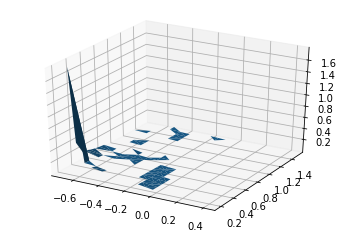

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df.log_moneyness, df.maturity, df.iv, linewidth=0.2)